# MG-Copter - demo notebook for RSD multipoles 

For the following example you need the Python wrapper for CAMB installed. The easiest way to do this is to use the `conda` package:

`conda install camb -c conda-forge`

In [1]:
import numpy as np
import camb

%matplotlib inline
import matplotlib.pyplot as plt

import pyreact

# import the builtin time module
import time

Set the cosmology and let CAMB compute the linear power spectrum.

In [2]:
# Set base cosmo parameters 
Omega_b = 0.046
Omega_c = 0.281-Omega_b
h = 0.697
n_s = 0.971
A_s = 2.31285e-9
m_nu = 0.0
w0 = -1.0
w_a = 0.0


# Model selection and parameter (gr,f(r),dgp,quintessence or cpl)
mymodel = "f(R)"
extrapars = np.zeros(20)
extrapars[0] = 1e-5


## Run camb to get the linear spectrum 

In [3]:
p = camb.CAMBparams(WantTransfer=True, 
                    Want_CMB=False, Want_CMB_lensing=False, DoLensing=False, 
                    NonLinear="NonLinear_none",
                    WantTensors=False, WantVectors=False, WantCls=False, WantDerivedParameters=False,
                    want_zdrag=False, want_zstar=False, DarkEnergyModel="fluid")
    
p.set_cosmology(H0=h*100, ombh2=Omega_b*h**2, omch2=Omega_c*h**2, omk=0, mnu=m_nu)
p.set_initial_power(camb.initialpower.InitialPowerLaw(As=A_s, ns=n_s))
p.set_dark_energy(w=w0,wa=w_a)

p.set_matter_power(redshifts=np.linspace(0.0, 1.0, 2, endpoint=True)[::-1],
                   kmax=50.0, nonlinear=False)

r = camb.get_results(p)
sigma_8 = r.get_sigma8()[-1]
k_lin, z_lin, pofk_lin_camb = r.get_matter_power_spectrum(minkh=1e-4, maxkh=50.0, npoints=128)

Omega_m = p.omegam
print(sigma_8)

0.8448071967423182


## Now run MG-Copter to get the multipoles and the modified gravity growth 

In [4]:
react = pyreact.ReACT()

# target redshift 
z_react =  0.5 

# Set rsd parameters 
# 0 = kaiser # 1 = TNS with q-bias  # 2 = TNS with eulerian bias # 3 = 1-loop SPT 
rsd_model = 1 

# how many multipoles to calculate? 
whichmulti = 3

# RSD parameters
rsdpars = np.zeros(1)
# 0 = sigma_v of TNS model 
# for rsd_model = 3 the linear velocity dispersion is calculated internally and rsdpars is ignored. 
rsdpars[0] = 3.0 

# bias parameters 
# 0 = linear bias 
# 1+ : higher order bias (see reactions/src/SPT.cpp PRSD_mg function)
biaspars = np.zeros(4)
biaspars[0] = 1.0
biaspars[1] = 0.0
biaspars[2] = 0.0

# Set output array 
kmin = 1e-2
kmax = 0.3
kloop = 60
kout = np.logspace(np.log10(kmin), np.log10(kmax), num=kloop)

# error parameters 
# 0 = 1-loop integral absolute accuracy 
# 1 = evolution equation starting step 
# 2,3 = evolution equation absolute and relative errors
errpars = np.zeros(4)
errpars[0] = 1e-3
errpars[1] = 1e-4
errpars[2] = 1e-3
errpars[3] = 1e-2


# Grab Currrent Time Before Running the Code
start = time.time()

p0,p2,p4,growth_factor, growth_rate = react.compute_multipoles(
                                h, n_s, Omega_m, Omega_b, sigma_8, z_react, k_lin, pofk_lin_camb[0],
                                kout,
                                mymodel, rsd_model, whichmulti, 
                                extrapars, rsdpars, biaspars, errpars,
                                is_transfer=False,
                                verbose=True)  

# Grab Currrent Time After Running the Code
end = time.time()

#Subtract Start Time from The End Time
total_time = end - start
print("\n"+ str(total_time))


209.41569304466248


(0.01, 0.3)

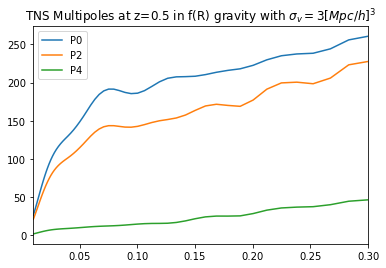

In [6]:
import pylab as pl

pl.title("TNS Multipoles at z=0.5 in f(R) gravity with $\sigma_v = 3 [Mpc/h]^3$")
pl.plot(kout, kout**(3/2)*p0 , label="P0")
pl.plot(kout, kout**(3/2)*p2, label = "P2")
pl.plot(kout, kout**(3/2)*p4, label = "P4")

pl.legend(loc='best')
pl.xlim(0.01,0.3)